In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
from scipy.io import wavfile
from scipy.signal import spectrogram

In [10]:
y_train = pd.read_csv("data\Y_train_ofTdMHi.csv")

# 1. EDA

## Analyze the target variable

In [11]:
y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


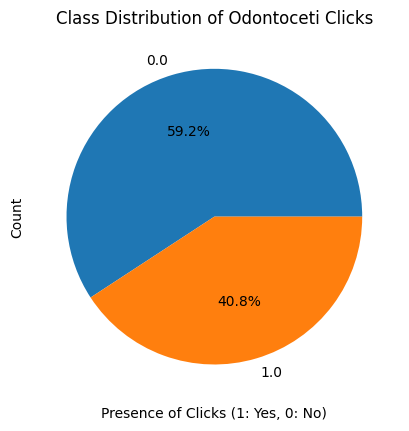

In [13]:
#Visualize the repartition of the target variable 
y_train['pos_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Class Distribution of Odontoceti Clicks")
plt.xlabel("Presence of Clicks (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()


In [12]:
# Extract location information from file names
y_train["location"] = y_train["id"].apply(lambda x: x.split("-")[-1].split(".")[0])

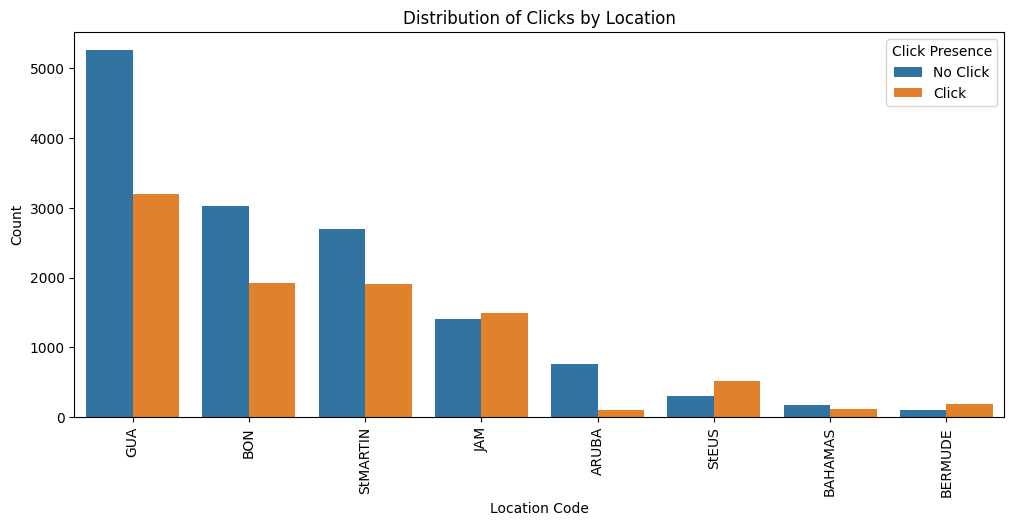

In [17]:
# Location-based distribution plot
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train["location"], hue=y_train["pos_label"], order=y_train["location"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Clicks by Location")
plt.xlabel("Location Code")
plt.ylabel("Count")
plt.legend(title="Click Presence", labels=["No Click", "Click"])
plt.show()

Certain locations may have more odontoceti clicks, indicating regional differences in marine life activity.

## Audio Data Exploration

In [ ]:
#Load audio files
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_data = {}
for file in audio_files:
    y, sr = librosa.load(file, sr=None)  # Load with original sampling rate
    audio_data[file] = (y, sr)

# Extract basic properties
audio_properties = []
for file, (y, sr) in audio_data.items():
    duration = len(y) / sr
    min_amplitude = np.min(y)
    max_amplitude = np.max(y)
    audio_properties.append([file, sr, duration, min_amplitude, max_amplitude])

audio_df = pd.DataFrame(audio_properties, columns=["File", "Sampling Rate (Hz)", "Duration (s)", "Min Amplitude", "Max Amplitude"])


In [ ]:
audio_df.head()

,File,Sampling Rate (Hz),Duration (s),Min Amplitude,Max Amplitude
0,data/X_train\00000-JAM.wav,256000,0.2,-0.001831,0.012329
1,data/X_train\00001-JAM.wav,256000,0.2,-0.009766,0.018646
2,data/X_train\00002-JAM.wav,256000,0.2,-0.013580,0.018646
3,data/X_train\00003-JAM.wav,256000,0.2,-0.013580,0.018646
4,data/X_train\00004-JAM.wav,256000,0.2,-0.013580,0.018646


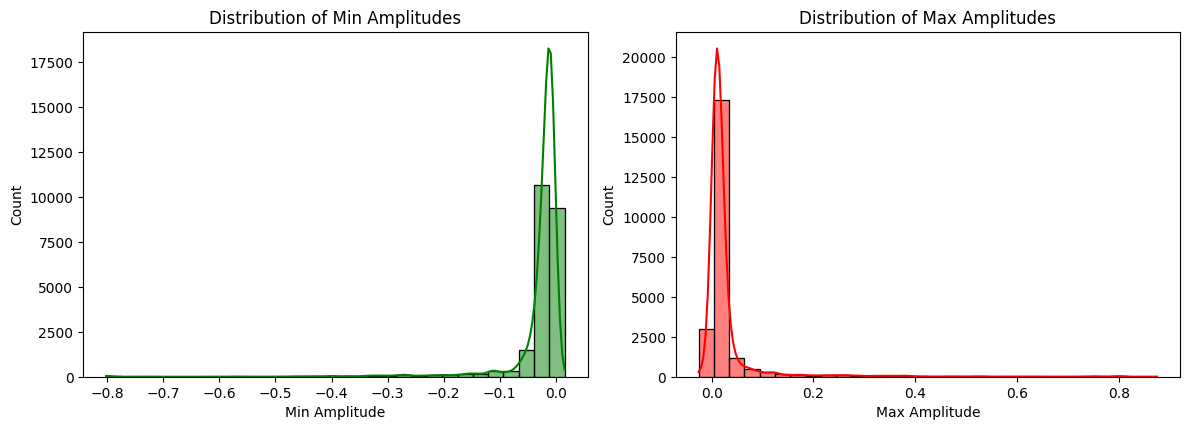

In [ ]:
plt.figure(figsize=(12, 8))

# Min Amplitude distribution
plt.subplot(2, 2, 1)
sns.histplot(audio_df["Min Amplitude"], bins=30, kde=True, color="green")
plt.xlabel("Min Amplitude")
plt.ylabel("Count")
plt.title("Distribution of Min Amplitudes")

# Max Amplitude distribution
plt.subplot(2, 2, 2)
sns.histplot(audio_df["Max Amplitude"], bins=30, kde=True, color="red")
plt.xlabel("Max Amplitude")
plt.ylabel("Count")
plt.title("Distribution of Max Amplitudes")

plt.tight_layout()
plt.show()


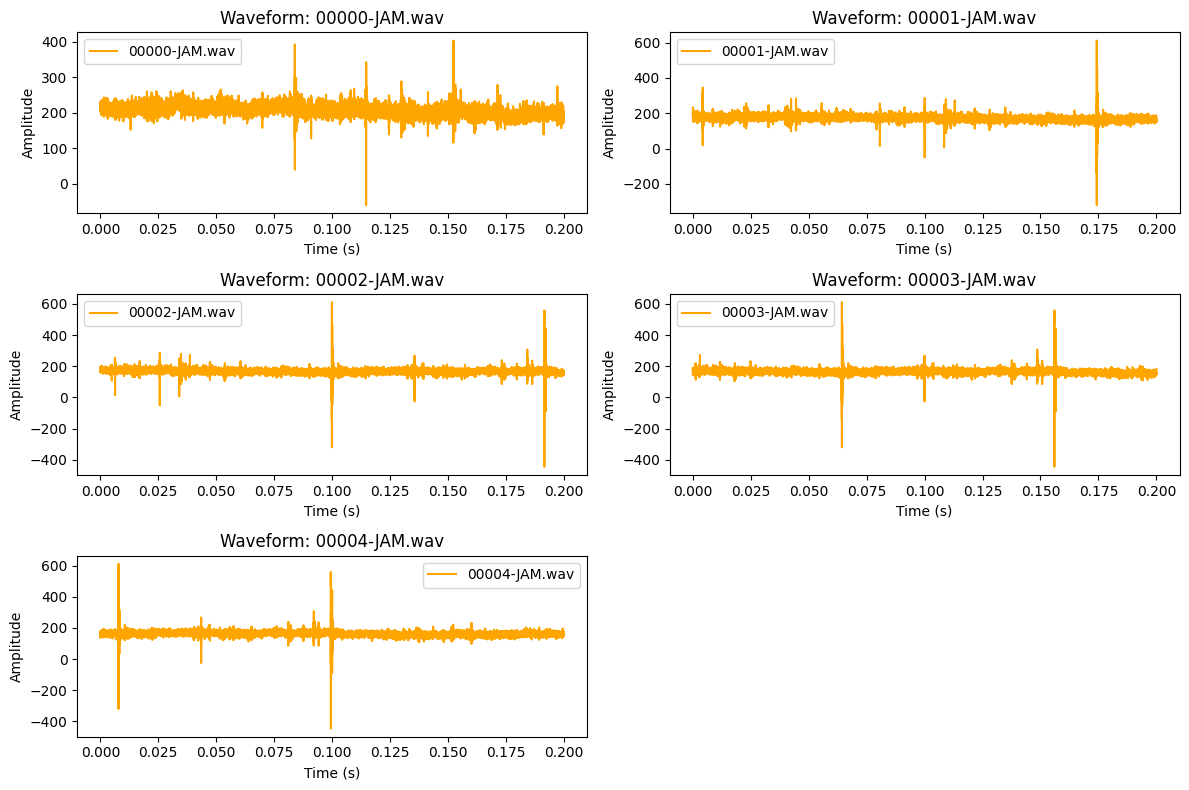

In [29]:
# Select a subset of files for visualization (first 5 files)
subset_files = audio_files[:5]

# Plot waveforms
plt.figure(figsize=(12, 8))
for i, file in enumerate(subset_files):
    sr, y = wavfile.read(file)
    time = np.linspace(0, len(y) / sr, num=len(y))
    
    plt.subplot(3, 2, i + 1)
    plt.plot(time, y, label=os.path.basename(file), color="orange")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform: {os.path.basename(file)}")
    plt.legend()

plt.tight_layout()
plt.show()


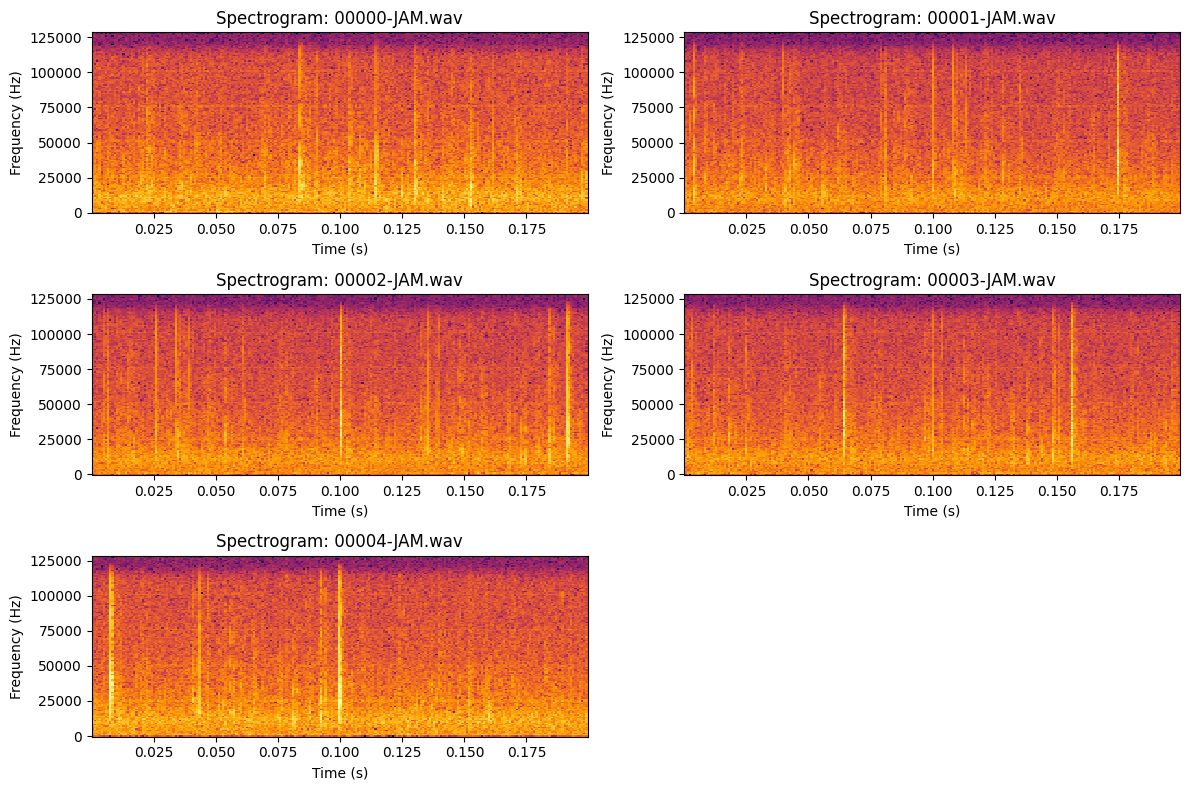

In [32]:
# Compute and display spectrograms for a subset of audio files
plt.figure(figsize=(12, 8))

for i, file in enumerate(subset_files):
    sr, y = wavfile.read(file)
    f, t, Sxx = spectrogram(y, fs=sr)
    
    plt.subplot(3, 2, i + 1)
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='auto', cmap="inferno")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Spectrogram: {os.path.basename(file)}")

plt.tight_layout()
plt.show()


## Feature extraction

 - Spectral Centroid: Measures the center of mass of the spectrum, indicating "brightness" of the sound.
 - Spectral Bandwidth: Measures how spread out the spectrum is around the centroid.
 - Zero-Crossing Rate (ZCR): Counts how often the signal crosses zero; useful for detecting transients
 - MFCCs (Mel Frequency Cepstral Coefficients): Captures sound characteristics in a compressed way, useful for classification.
 - Spectrogram Analysis: Provides a visual representation of frequency content over time.
 - RMS Energy: Measures the overall power of the audio signal, representing its loudness and intensity.
 - Spectral Flatness: Quantifies how noise-like or tone-like a sound is; a high value indicates noise, while a low value suggests tonal structure.


In [39]:
# Compute statistical aggregations for extracted features
extended_features = []

for file in audio_files:
    sr, y = wavfile.read(file)
    
    # Apply Bandpass Filter (5000Hz - 100kHz)
    sos = signal.butter(6, [5000, 100000], 'bandpass', fs=sr, output='sos')
    y_filtered = signal.sosfiltfilt(sos, y)
    
    # Compute RMS Energy statistics
    rms_values = np.sqrt(y_filtered**2)
    rms_mean, rms_std, rms_min, rms_max = np.mean(rms_values), np.std(rms_values), np.min(rms_values), np.max(rms_values)
    
    # Compute Spectral Centroid statistics
    f, t, Sxx = spectrogram(y_filtered, fs=sr)
    spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
    sc_mean, sc_std, sc_min, sc_max = np.mean(spectral_centroid), np.std(spectral_centroid), np.min(spectral_centroid), np.max(spectral_centroid)
    
    # Compute Spectral Bandwidth statistics
    spectral_bandwidth = np.std(f[:, None] * Sxx, axis=0)
    sb_mean, sb_std, sb_min, sb_max = np.mean(spectral_bandwidth), np.std(spectral_bandwidth), np.min(spectral_bandwidth), np.max(spectral_bandwidth)
    
    # Compute Spectral Flatness statistics
    spectral_flatness = 10 * np.log10(np.var(Sxx, axis=0) / np.mean(Sxx, axis=0))
    sf_mean, sf_std, sf_min, sf_max = np.mean(spectral_flatness), np.std(spectral_flatness), np.min(spectral_flatness), np.max(spectral_flatness)
    
    # Compute Zero-Crossing Rate statistics
    zcr_values = np.diff(np.sign(y_filtered)) != 0
    zcr_mean, zcr_std, zcr_min, zcr_max = np.mean(zcr_values), np.std(zcr_values), np.min(zcr_values), np.max(zcr_values)
    
    # Approximate MFCCs using FFT
    mfccs = np.abs(np.fft.fft(y_filtered))[:13]  # Extract first 13 coefficients
    mfccs_mean, mfccs_std, mfccs_min, mfccs_max = np.mean(mfccs), np.std(mfccs), np.min(mfccs), np.max(mfccs)
    extended_features.append([file, sr, rms_mean, rms_std, rms_min, rms_max,
                              sc_mean, sc_std, sc_min, sc_max, sb_mean, sb_std, sb_min, sb_max,
                              sf_mean, sf_std, sf_min, sf_max, zcr_mean, zcr_std, zcr_min, zcr_max,
                              mfccs_mean, mfccs_std, mfccs_min, mfccs_max])

columns = ["File", "Sampling Rate (Hz)", 
           "RMS_Mean", "RMS_Std", "RMS_Min", "RMS_Max", 
           "Spectral_Centroid_Mean", "Spectral_Centroid_Std", "Spectral_Centroid_Min", "Spectral_Centroid_Max",
           "Spectral_Bandwidth_Mean", "Spectral_Bandwidth_Std", "Spectral_Bandwidth_Min", "Spectral_Bandwidth_Max",
           "Spectral_Flatness_Mean", "Spectral_Flatness_Std", "Spectral_Flatness_Min", "Spectral_Flatness_Max",
           "ZCR_Mean", "ZCR_Std", "ZCR_Min", "ZCR_Max",
           "MFCC_Mean", "MFCC_Std", "MFCC_Min", "MFCC_Max"]

features_df = pd.DataFrame(extended_features, columns=columns)
features_df.head()


C:\Users\vongu\AppData\Local\Temp\ipykernel_32488\3113967003.py:17: RuntimeWarning: invalid value encountered in divide
  spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
C:\Users\vongu\AppData\Local\Temp\ipykernel_32488\3113967003.py:25: RuntimeWarning: invalid value encountered in divide
  spectral_flatness = 10 * np.log10(np.var(Sxx, axis=0) / np.mean(Sxx, axis=0))
C:\Users\vongu\AppData\Local\Temp\ipykernel_32488\3113967003.py:25: RuntimeWarning: divide by zero encountered in log10
  spectral_flatness = 10 * np.log10(np.var(Sxx, axis=0) / np.mean(Sxx, axis=0))
c:\Users\vongu\OneDrive\Desktop\DL_projet\Detection_de_clics_Odontocetes\venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,File,Sampling Rate (Hz),RMS_Mean,RMS_Std,RMS_Min,RMS_Max,Spectral_Centroid_Mean,Spectral_Centroid_Std,Spectral_Centroid_Min,Spectral_Centroid_Max,...,Spectral_Flatness_Min,Spectral_Flatness_Max,ZCR_Mean,ZCR_Std,ZCR_Min,ZCR_Max,MFCC_Mean,MFCC_Std,MFCC_Min,MFCC_Max
0,data/X_train\00000-JAM.wav,256000,7.499052,7.110701,0.000038,268.750347,20240.693405,2937.909192,13574.449174,31132.775370,...,-28.500392,-12.598350,0.186605,0.389594,False,True,78.925713,0.001802,78.923779,78.929348
1,data/X_train\00001-JAM.wav,256000,7.812400,8.865479,0.000718,503.330598,20948.742355,4137.623465,14424.992683,43601.339898,...,-28.645663,-6.923425,0.189437,0.391856,False,True,10.726737,0.000163,10.726409,10.726912
2,data/X_train\00002-JAM.wav,256000,7.732652,10.124392,0.000718,580.622449,21081.393952,4290.048919,14454.499216,43656.915850,...,-28.286957,-6.928943,0.193070,0.394708,False,True,3.371800,0.000937,3.370794,3.373690
3,data/X_train\00003-JAM.wav,256000,7.601834,9.820459,0.000397,580.622449,20678.993172,4059.494422,13373.177445,40767.109002,...,-28.678101,-7.146112,0.190765,0.392905,False,True,163.143873,0.003698,163.139904,163.151335
4,data/X_train\00004-JAM.wav,256000,7.590016,9.806704,0.000134,580.622449,20420.903707,3833.473431,13908.514351,40926.290732,...,-29.145472,-11.383732,0.187191,0.390065,False,True,72.050416,0.002827,72.047382,72.056121


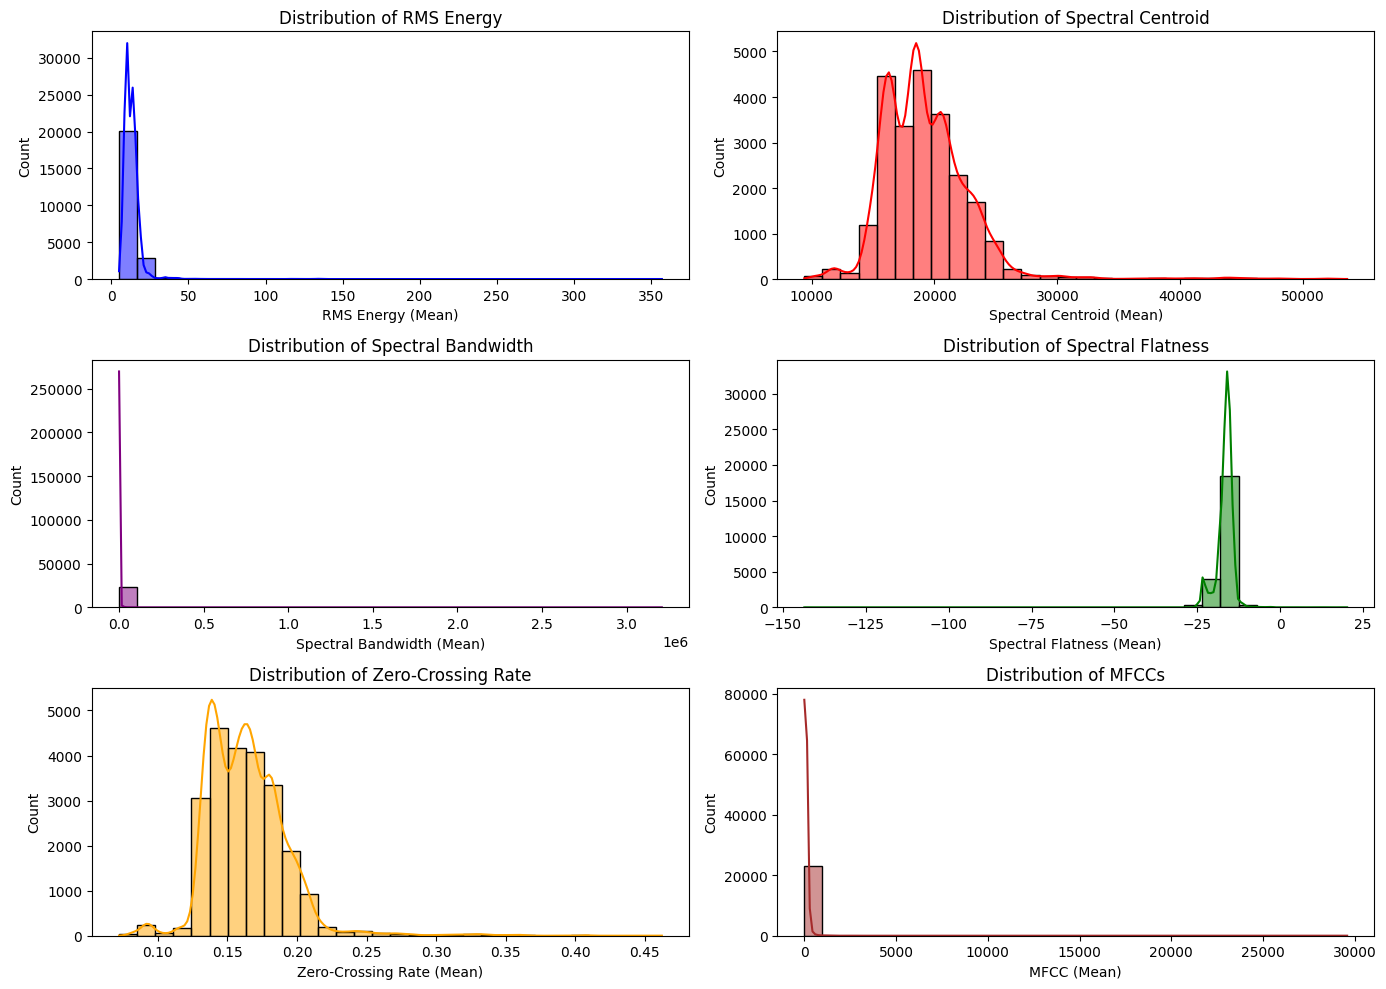

In [40]:
# Visualize feature distributions
plt.figure(figsize=(14, 10))

# RMS Energy distribution
plt.subplot(3, 2, 1)
sns.histplot(features_df["RMS_Mean"], bins=30, kde=True, color="blue")
plt.xlabel("RMS Energy (Mean)")
plt.ylabel("Count")
plt.title("Distribution of RMS Energy")

# Spectral Centroid distribution
plt.subplot(3, 2, 2)
sns.histplot(features_df["Spectral_Centroid_Mean"], bins=30, kde=True, color="red")
plt.xlabel("Spectral Centroid (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Centroid")

# Spectral Bandwidth distribution
plt.subplot(3, 2, 3)
sns.histplot(features_df["Spectral_Bandwidth_Mean"], bins=30, kde=True, color="purple")
plt.xlabel("Spectral Bandwidth (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Bandwidth")

# Spectral Flatness distribution
plt.subplot(3, 2, 4)
sns.histplot(features_df["Spectral_Flatness_Mean"], bins=30, kde=True, color="green")
plt.xlabel("Spectral Flatness (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Flatness")

# Zero-Crossing Rate distribution
plt.subplot(3, 2, 5)
sns.histplot(features_df["ZCR_Mean"], bins=30, kde=True, color="orange")
plt.xlabel("Zero-Crossing Rate (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Zero-Crossing Rate")

# MFCC Mean distribution
plt.subplot(3, 2, 6)
sns.histplot(features_df["MFCC_Mean"], bins=30, kde=True, color="brown")
plt.xlabel("MFCC (Mean)")
plt.ylabel("Count")
plt.title("Distribution of MFCCs")

plt.tight_layout()
plt.show()
